## Processing UKCP data for the RED-UP project 

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio import features
import rioxarray
from adjustText import adjust_text
from datetime import datetime, timedelta
import seaborn as sns
import cmocean
import os 
from urllib.parse import urlparse
from netCDF4 import Dataset
import xarray as xr
import io
import iris
#os.environ['ESMFMKFILE'] = '/home/shardy08/miniforge3/envs/xesmf_env/lib/esmf.mk'
#import xesmf as xe
sns.set_theme()

## Read in Kay's processed data that identifies unphysical rainfall features

- Filter the rainfall data to focus on the parameters we're interested in
    - `Max_Accum` values between 25 and 35 (mm/hr)
    - `Max_RATIO` values over 100 (how much precip in 1 hour relative to the other 5 hours in the 6-h period)
- Extract the `day`, `month`, `year` and `hour` parts from the `end_date` column
    - TODO: find the root cause of the warning messages below and address the issue
- Write a function to modify the date string to account for the time offset 
    - Calculate the time offset for the maximum rainfall in the 6-h period 
    - Adjust the day, month and year for consistency with the 360-day calendar

In [2]:
ensemble_member = '04'
feature_path = '/mnt/c/Users/samhardy/OneDrive - JBA Group/2024s1475_RED_UP'
data_path = f'{feature_path}/csv_data/Extract_Prof_proj1_e{ensemble_member}_6h_ratio_ge15.csv'
rainfall_feature_data = pd.read_csv(data_path)

rainfall_features_filtered = rainfall_feature_data[(rainfall_feature_data['Max_Accum'] <= 40) & 
                                                   (rainfall_feature_data['Max_Accum'] >= 25) &
                                                   (rainfall_feature_data['Max_RATIO'] >= 100)]

rainfall_features_filtered[['day', 'month', 'year', 'hour']] = rainfall_features_filtered['end_date'].str.extract(
    r'(\d+)/(\d+)/(\d+) (\d+):\d+').astype(int)

def calculate_precip_time_offset(row):
    """ 
    Calculate the offset (between 0 and 5 h) for each value of hourly rainfall
    """
    column = row['Max_TIME']
    hours_offset = 6 - int(column)  # Extract hour offset
    adjusted_hour = row['hour'] - hours_offset
    adjusted_day = row['day']
    adjusted_month = row['month']
    adjusted_year = row['year']

    while adjusted_hour < 0:
        adjusted_hour += 24
        adjusted_day -= 1
    while adjusted_day < 1:
        adjusted_day += 30
        adjusted_month -= 1
    while adjusted_month < 1:
        adjusted_month += 12
        adjusted_year -= 1

    return f"{adjusted_day:02d}/{adjusted_month:02d}/{adjusted_year:04d} {adjusted_hour:02d}:30"

rainfall_features_filtered['end_date_adjusted'] = rainfall_features_filtered.apply(calculate_precip_time_offset, axis=1)

/tmp/ipykernel_14070/1842120309.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_features_filtered[['day', 'month', 'year', 'hour']] = rainfall_features_filtered['end_date'].str.extract(
/tmp/ipykernel_14070/1842120309.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfall_features_filtered[['day', 'month', 'year', 'hour']] = rainfall_features_filtered['end_date'].str.extract(
/tmp/ipykernel_14070/1842120309.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

### While the UKCP data is unavailable, try looking into the csv data

- START FROM HERE: select by `group_ID`

In [3]:
rainfall_features_filtered

,Projection_slice_ID,Member,WCID,end_date,lon,lat,Total_accum,TIME_1,TIME_2,TIME_3,...,Max_TIME,YEAR,MONTH,group_id,Max_RATIO,day,month,year,hour,end_date_adjusted
0,1,4,0,12/06/1999 13:30,-7.57,56.94,35.22,0.00,0.00,0.00,...,5,1999,6,14,105.031250,12,6,1999,13,12/06/1999 12:30
9,1,4,0,19/12/1985 05:30,-7.50,57.01,35.88,0.56,0.04,0.00,...,5,1985,12,41,130.946970,19,12,1985,5,19/12/1985 04:30
22,1,4,0,01/08/1988 14:30,-7.43,57.65,35.53,0.00,0.00,0.31,...,4,1988,8,116,122.805755,1,8,1988,14,01/08/1988 12:30
37,1,4,0,17/07/1981 16:30,-7.39,57.27,35.77,0.00,0.05,34.11,...,3,1981,7,173,102.740964,17,7,1981,16,17/07/1981 13:30
63,1,4,0,15/06/1982 17:30,-7.37,57.45,36.00,1.02,34.99,0.00,...,2,1982,6,276,171.519608,15,6,1982,17,15/06/1982 13:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61084,1,4,12,16/07/1998 17:30,-1.91,53.40,39.71,0.39,39.23,0.04,...,2,1998,7,487174,408.645833,16,7,1998,17,16/07/1998 13:30
61090,1,4,12,21/08/1989 16:30,-1.91,53.46,38.81,37.46,0.54,0.00,...,1,1989,8,487211,138.740741,21,8,1989,16,21/08/1989 11:30
61093,1,4,12,09/09/1981 14:30,-1.91,53.50,38.84,0.00,0.00,0.00,...,4,1981,9,487243,180.000000,9,9,1981,14,09/09/1981 12:30
61105,1,4,12,16/07/1988 17:30,-1.88,53.46,37.13,0.00,0.00,35.95,...,3,1988,7,487337,152.330509,16,7,1988,17,16/07/1988 14:30


### Work out which days have the most `weird features` occurring 

- currently need to manually change the index `[0]`, `[1]`, `[2]`, etc in the call to the variables below (`year`, `month`, etc)

In [4]:
event_counts = rainfall_features_filtered.groupby('end_date_adjusted').size().reset_index(name='event_count')
multiple_daily_events = event_counts[event_counts['event_count'] > 1].sort_values(by='event_count', ascending=False)
top_five_dates = multiple_daily_events.head()

def extract_dates_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Extract day, month and year strings from an input dataframe 
    """
    dates_df = df['end_date_adjusted'].str.extract(r'(\d+)/(\d+)/(\d+) (\d+):(\d+)').astype(str)
    dates_df.columns = ['day', 'month', 'year', 'hour', 'minute']
    return dates_df 

dates_df = extract_dates_from_df(top_five_dates)

year=str(dates_df.iloc[4]['year'])
month=str(dates_df.iloc[4]['month'])
day=str(dates_df.iloc[4]['day'])
hour=str(dates_df.iloc[4]['hour'])
minute=str(dates_df.iloc[4]['minute'])
date = f'{year}-{month}-{day} {hour}:{minute}'

## Set up an API request to download data for a specific date

- TODO: make this part much smoother

In [5]:
notebook=True
url=f'https://dap.ceda.ac.uk/badc/ukcp18/data/land-cpm/uk/2.2km/rcp85/{ensemble_member}/pr/1hr/v20210615/pr_rcp85_land-cpm_uk_2.2km_{ensemble_member}_1hr_{year}{month}01-{year}{month}30.nc?download=1'
var_id='pr'

### Download UKCP18 local projection data

- Taken from `https://github.com/cedadev/opendap-python-example/blob/master/remote_nc_with_token.py`

In [5]:
"""
remote_nc_with_token.py
===================

Python script for reading a NetCDF file remotely from the CEDA archive. It demonstrates fetching
and using a download token to authenticate access to CEDA Archive data, as well as how to load
and subset the Dataset from a stream of data (diskless), without having to download the whole file.

Pre-requisites:

 - Python3.x
 - Python libraries (installed by Pip):

```
netCDF4
```

Usage:

```
$ python remote_nc_with_token.py <url> <var_id>
```

Example:

```
$ URL=https://dap.ceda.ac.uk/badc/ukcp18/data/marine-sim/skew-trend/rcp85/skewSurgeTrend/latest/skewSurgeTrend_marine-sim_rcp85_trend_2007-2099.nc
$ VAR_ID=skewSurgeTrend

$ python remote_nc_with_token.py $URL $VAR_ID
```

You will be prompted to provide your CEDA username and password the first time the script is run and
again if the token cached from a previous attempt has expired.

"""

import argparse
import json
import os
import requests

from base64 import b64encode
from datetime import datetime, timezone
from getpass import getpass
from netCDF4 import Dataset
from urllib.parse import urlparse


# URL for the CEDA Token API service
TOKEN_URL = "https://services-beta.ceda.ac.uk/api/token/create/"
# Location on the filesystem to store a cached download token
TOKEN_CACHE = os.path.expanduser(os.path.join("~", ".cedatoken"))


def load_cached_token():
    """
    Read the token back out from its cache file.

    Returns a tuple containing the token and its expiry timestamp
    """

    # Read the token back out from its cache file
    try:
        with open(TOKEN_CACHE, "r") as cache_file:
            data = json.loads(cache_file.read())

            token = data.get("access_token")
            expires = datetime.strptime(data.get("expires"), "%Y-%m-%dT%H:%M:%S.%f%z")
            return token, expires

    except FileNotFoundError:
        return None, None


def get_token():
    """
    Fetches a download token, either from a cache file or
    from the token API using CEDA login credentials.

    Returns an active download token
    """

    # Check the cache file to see if we already have an active token
    token, expires = load_cached_token()

    # If no token has been cached or the token has expired, we get a new one
    now = datetime.now(timezone.utc)
    if not token or expires < now:

        if not token:
            print(f"No previous token found at {TOKEN_CACHE}. ", end="")
        else:
            print(f"Token at {TOKEN_CACHE} has expired. ", end="")
        print("Generating a fresh token...")

        print("Please provide your CEDA username: ", end="")
        username = input()
        password = getpass(prompt="CEDA user password: ")

        credentials = b64encode(f"{username}:{password}".encode("utf-8")).decode(
            "ascii"
        )
        headers = {
            "Authorization": f"Basic {credentials}",
        }
        response = requests.request("POST", TOKEN_URL, headers=headers)
        if response.status_code == 200:

            # The token endpoint returns JSON
            response_data = json.loads(response.text)
            token = response_data["access_token"]

            # Store the JSON data in the cache file for future use
            with open(TOKEN_CACHE, "w") as cache_file:
                cache_file.write(response.text)

        else:
            print("Failed to generate token, check your username and password.")

    else:
        print(f"Found existing token at {TOKEN_CACHE}, skipping authentication.")

    return token, expires


def open_dataset(url, download_token=None):
    """Open a NetCDF dataset from a remote file URL. Files requiring authentication
     will require an active download token associated with an authorised CEDa user.

    Returns a Python NetCDF4 Dataset object
    """

    headers = None
    # Add the download token to the request header if one is available
    if download_token:
        headers = {"Authorization": f"Bearer {download_token}"}

    response = requests.request("GET", url, headers=headers, stream=True, verify=False)
    if response.status_code != 200:
        print(
            f"Failed to fetch data. The response from the server was {response.status_code}"
        )
        return

    filename = os.path.basename(urlparse(url).path)
    print(f"Opening Dataset from file {filename} ...")
    # To avoid downloading the whole file, we create an "in-memory" Dataset from the response
    # See: https://unidata.github.io/netcdf4-python/#in-memory-diskless-datasets
    return Dataset(filename, memory=response.content)


if __name__ == "__main__":

    if not notebook:
        parser = argparse.ArgumentParser(
            prog="RemoteNetCDFWithToken",
            description=("Example script showing how to read a restricted-access remote NetCDF Dataset"
                " from the CEDA Archive using authentication tokens."),
        )

        parser.add_argument("url")
        parser.add_argument("var_id")

        args = parser.parse_args()

        url = args.url
        var_id = args.var_id

    token, expires = get_token()
    if token:
        # Now that we have a valid token, we can attempt to open the Dataset from a URL.
        # This will only work if the token is associated with a CEDA user that has been granted
        # access to the data (i.e. if they can already download the file in a browser).
        # 
        print(f"Fetching information about variable '{var_id}' using data URL: '{url}'")
        if token:
            print((
                f"Using download token '{token[:5]}...{token[-5:]}' for authentication."
                f" Token expires at: {expires}."
            ))
        else:
            print("No DOWNLOAD_TOKEN found in environment.")

        nc_data = open_dataset(url, download_token=token)

        # Now we can print some properties of the dataset.
        # 
        print("\n[INFO] Global attributes:")
        for attr in nc_data.ncattrs():
            print("\t{}: {}".format(attr, nc_data.getncattr(attr)))

        print("\n[INFO] Variables:\n{}".format(nc_data.variables))
        print("\n[INFO] Dimensions:\n{}".format(nc_data.dimensions))

        print("\n[INFO] Max and min variable: {}".format(var_id))
        variable = nc_data.variables[var_id][:]
        units = nc_data.variables[var_id].units
        print(
            "\tMin: {:.6f} {}; Max: {:.6f} {}".format(
                variable.min(), units, variable.max(), units
            )
        )

        ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_data))

    else:
        # The script wont run without a token since attempting to open a restricted file
        # without authentication will give an unhelpful error. Though, open access datasets
        # can be accessed without a token.
        # 
        # i.e.
        # dataset = open_dataset(url, download_token=None)
        #
        print("Aborting since we don't have a token.")

Token at /home/shardy08/.cedatoken has expired. Generating a fresh token...
Please provide your CEDA username: 

SSLError: HTTPSConnectionPool(host='services-beta.ceda.ac.uk', port=443): Max retries exceeded with url: /api/token/create/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)')))

### Process the UKCP data using Iris

- Preferred to `xarray` here because it handles the rotated pole grid without the need for regridding

In [ ]:
from ncdata.iris_xarray import cubes_from_xarray, cubes_to_xarray
import iris.quickplot as qplt
import iris.coord_categorisation as icc
from datetime import datetime 
from cftime import Datetime360Day

cubes = cubes_from_xarray(ds)
cube = cubes[0]

cube_copy = cube.copy()
icc.add_categorised_coord(cube_copy, 'datetime', 'time', lambda coord, x: coord.units.num2date(x))
datetime_date = Datetime360Day(int(year), int(month), int(day), int(hour), int(minute))
datetime_coord = cube_copy.coord('datetime')
matching_indices = [i for i, dt in enumerate(datetime_coord.points) if dt == datetime_date]

### Develop some code to find the nearest grid point to each of the markers

In [ ]:
def find_nearest_grid_indices(cube, lat, lon):
    """ 
    Find the nearest grid indices (lat, lon) to the rainfall features in the csv file
    """
    latitudes = cube.coord('latitude').points
    longitudes = cube.coord('longitude').points

    # Calculate distances to all grid points
    distances = np.sqrt((latitudes - lat)**2 + (longitudes - lon)**2)
    idx_flat = np.argmin(distances)

    # Convert flat index back to 2D indices
    lat_idx, lon_idx = np.unravel_index(idx_flat, latitudes.shape)
    return lat_idx, lon_idx

output_date_str = f'{day}{month}{year}_{hour}{minute}'

weird_features_df = rainfall_features_filtered[
    rainfall_features_filtered['end_date_adjusted'] == f'{day}/{month}/{year} {hour}:{minute}'
    ]

### Loop through the dataframe rows and find the nearest indices to each feature

- Overlay the features from the csv 
- TODO: annotate the plot with any relevant metadata (ensemble member, max accumulated rainfall, etc)

/home/shardy08/miniforge3/envs/xesmf_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


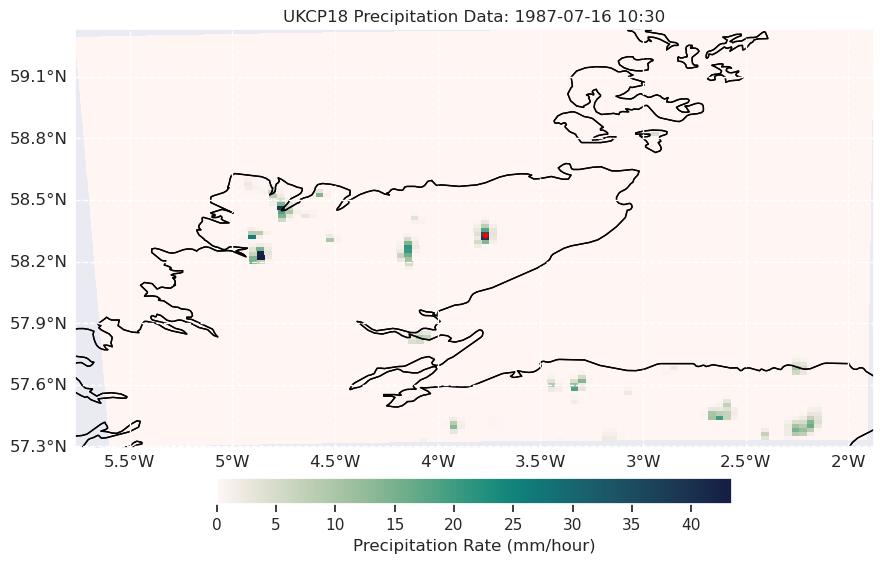

/home/shardy08/miniforge3/envs/xesmf_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


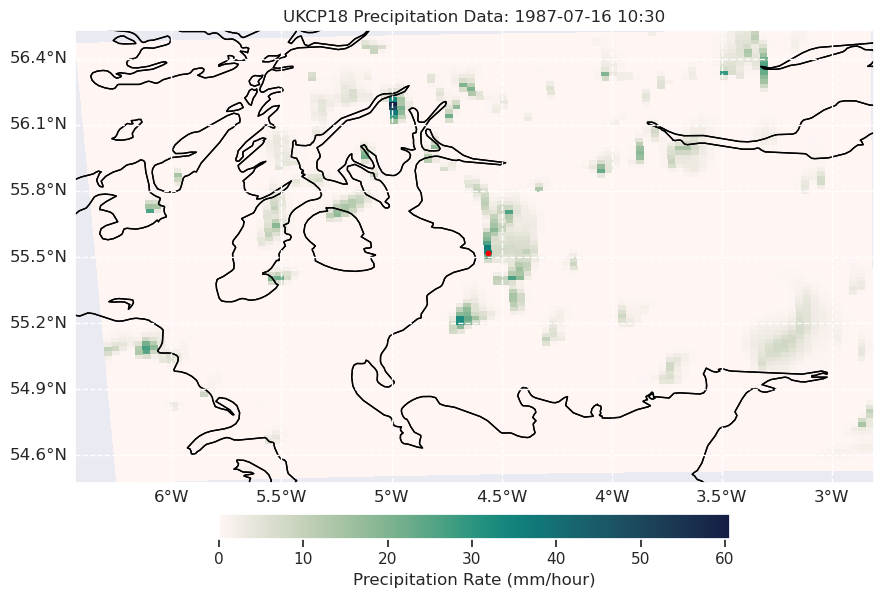

/home/shardy08/miniforge3/envs/xesmf_env/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


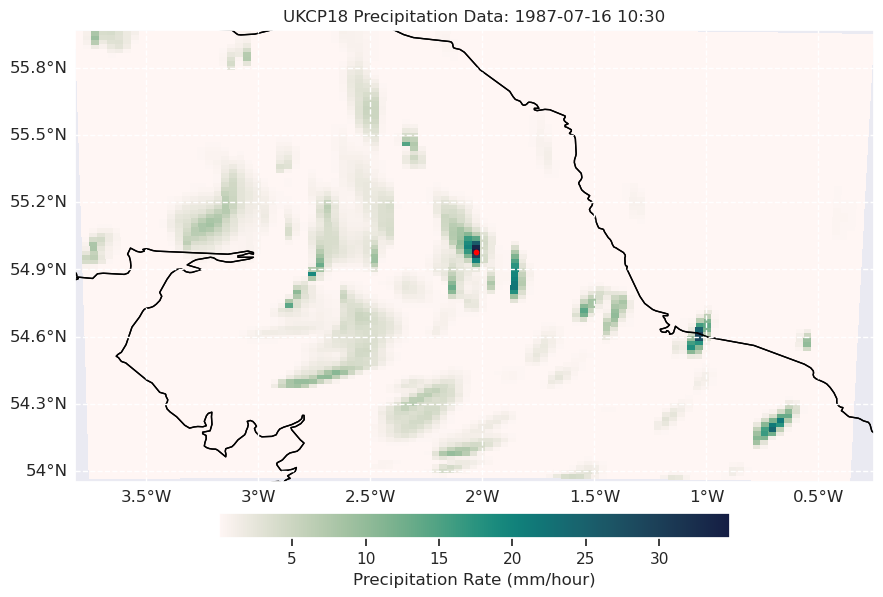

In [ ]:
grid_range = 50 # number of grid points to plot either side of the rainfall feature 
feature_count = 0 # counter for looping through each rainfall feature when plotting 

for _, row in weird_features_df.iterrows():
    lat = row['lat']
    lon = row['lon']

    lat_idx, lon_idx = find_nearest_grid_indices(cube[0,0],
                                                 lat,
                                                 lon)
    
    lat_start = max(0, lat_idx - grid_range)
    lat_end = min(cube.shape[-2], lat_idx + grid_range)
    lon_start = max(0, lon_idx - grid_range)
    lon_end = min(cube.shape[-1], lon_idx + grid_range)

    cube_subset = cube[0,
                       matching_indices[0],
                       lat_start:lat_end,
                       lon_start:lon_end]

    fig, ax = plt.subplots(figsize=(9,6), 
                        subplot_kw={'projection': ccrs.PlateCarree()})
    
    p = iris.plot.pcolormesh(cube_subset, 
                             cmap=cmocean.cm.tempo, 
                             axes=ax)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', color='black')
    ax.add_feature(cfeature.COASTLINE, linestyle='-', color='black')

    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax.scatter(row['lon'],
               row['lat'],
               color='red',
               s=10,
               transform=ccrs.PlateCarree())

    cbar = plt.colorbar(p, 
                        orientation='horizontal', 
                        ax=ax, 
                        fraction=0.05, 
                        pad=0.06)
    cbar.set_label('Precipitation Rate (mm/hour)')

    ax.set_title(f"UKCP18 Precipitation Data: {date}")

    plt.tight_layout()
    plt.show()
    feature_count += 1
    fig.savefig(f'{feature_path}/hourly_rainfall_zoom_{output_date_str}_{str(feature_count)}.png', dpi=500)